In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, losses, metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [ ]:
!unzip drive/MyDrive/Colab\ Notebooks/ROBOTICS/project-jetbot/dataset-final.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset/nice_race/0501.jpg:Zone.Identifier  
 extracting: dataset/nice_race/0929.jpg:Zone.Identifier  
  inflating: dataset/nice_race/0609.jpg  
 extracting: dataset/nice_race/0197.jpg:Zone.Identifier  
  inflating: dataset/nice_race/0656.jpg  
 extracting: dataset/nice_race/0859.jpg:Zone.Identifier  
  inflating: dataset/nice_race/0321.jpg  
  inflating: dataset/nice_race/0813.jpg  
 extracting: dataset/nice_race/0662.jpg:Zone.Identifier  
  inflating: dataset/nice_race/0435.jpg  
 extracting: dataset/nice_race/0731.jpg:Zone.Identifier  
 extracting: dataset/nice_race/0604.jpg:Zone.Identifier  
  inflating: dataset/nice_race/0542.jpg  
  inflating: dataset/nice_race/0339.jpg  
  inflating: dataset/nice_race/0604.jpg  
  inflating: dataset/nice_race/0861.jpg  
  inflating: dataset/nice_race/0717.jpg  
  inflating: dataset/nice_race/0818.jpg  
  inflating: dataset/nice_race/0226.jpg  
  inflating: dataset/nice_race/0432.jpg

In [ ]:
from pathlib import Path
import pandas as pd
import cv2
import numpy as np

X = []
y = []

DS = Path("dataset")
FRAMES_TO_STACK = 5
FINAL_HEIGHT = 140

movies = []
recordings = sorted(DS.glob("*.csv"))
for recording in recordings:
    csvfile = Path(recording).name
    print("Loading: ", csvfile)
    df = pd.read_csv(DS / csvfile, header=None)
    y.extend(df[[2]].to_numpy())
    recordid = csvfile[:-4]
    img_files = sorted((DS / recordid).glob("*.jpg"))
    movie = []
    for filename in img_files:
        file = cv2.imread(str(filename))
        movie.append(file)
    movies.append(movie)

Loading:  376_1.csv
Loading:  456_1.csv
Loading:  456_2.csv
Loading:  493_1.csv
Loading:  493_2.csv
Loading:  493_3.csv
Loading:  good_turns.csv
Loading:  good_turns_bog.csv
Loading:  long.csv
Loading:  long_turns.csv
Loading:  nice_race.csv
Loading:  our_fast.csv
Loading:  our_fast_short.csv
Loading:  our_good_driving.csv
Loading:  the-cones.csv
Loading:  the-red-kettle.csv
Loading:  the-short.csv
Loading:  the-speedy-cones.csv
Loading:  turn_left.csv
Loading:  zip_skipper.csv


In [ ]:
import matplotlib.pyplot as plt
import cv2

def preprocess(img, show=False):
    def region_of_interest(image):
        height, width = image.shape[:2]
        # Define the trapezoid vertices
        vertices = np.array([
            [(0, height),  # Bottom-left
            (width, height),  # Bottom-right
            (width * 0.6, height * 0.4),  # Top-right
            (width * 0.4, height * 0.4)]  # Top-left
        ], dtype=np.int32)
        mask = np.zeros_like(image)
        cv2.fillPoly(mask, vertices, 255)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 60, 100)
    dilated = cv2.dilate(canny, kernel=(5,5))

    masked = region_of_interest(dilated)
    if show:
        plt.imshow(masked, cmap="gray")
    return masked

In [ ]:
movies_processed = []
for movie in movies:
    movie_processed = []
    for frame in movie:
        movie_processed.append(preprocess(frame))
    movies_processed.append(movie_processed)

X = []
for movie in movies_processed:
    for frame in movie:
        X.append(frame)

X = np.array(X)
X = X[...,np.newaxis]
y = np.array(y)

In [ ]:
X.shape

(8734, 224, 224, 1)

In [ ]:
y.shape

(8734, 1)

In [ ]:
import keras

In [ ]:
input_shape = X.shape[1:]
input_shape

(224, 224, 1)

In [ ]:
X = X.astype(np.float32) / 255.0

In [ ]:
class NoiseAugmentation(tf.keras.layers.Layer):
    def __init__(self, mutation_prob=0.05):
        super(NoiseAugmentation, self).__init__()
        self.mutation_prob = mutation_prob

    def call(self, inputs, training=None):
        if training:
            # Generate random noise with the same shape as the inputs
            noise = tf.random.uniform(tf.shape(inputs), minval=0, maxval=1)

            # Create a mask where each pixel has a probability of mutation_prob to be changed
            mask = tf.cast(noise < self.mutation_prob, tf.bool)

            # Generate random noise with the same shape as the inputs
            random_values = tf.random.uniform(tf.shape(inputs), minval=0, maxval=2, dtype=tf.float32)

            # Set random indices to 0 or 1 based on the mask
            augmented_inputs = tf.where(mask, random_values, inputs)
        else:
            augmented_inputs = inputs

        return augmented_inputs

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Input(input_shape))
#model.add(NoiseAugmentation(mutation_prob=0.05))

# First convolutional layer
model.add(keras.layers.Conv2D(8, kernel_size=(3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for feeding into dense layers
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dropout(0.2))  # 20% dropout

# Output layer (modify the number of units based on your classification problem)
model.add(keras.layers.Dense(1, activation="tanh"))  # 10 units for 10 class classification

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 222, 222, 8)       80        
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 111, 111, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 54, 54, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 52, 52, 16)        2320      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 26, 26, 16)       

In [ ]:
model.compile(optimizer='adam',
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanAbsoluteError(),
                       metrics.RootMeanSquaredError()])

checkpoint_cb = ModelCheckpoint('model_checkpoint.h5', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=10, min_lr=0.00001, verbose=1)

In [ ]:
history = model.fit(X, y, epochs=1000, validation_split=0.66, callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb])

Epoch 1/1000
93/93 [==============================] - 6s 52ms/step - loss: 0.2125 - mean_absolute_error: 0.3389 - root_mean_squared_error: 0.4609 - val_loss: 0.2324 - val_mean_absolute_error: 0.3445 - val_root_mean_squared_error: 0.4821 - lr: 0.0010
Epoch 2/1000
 9/93 [=>............................] - ETA: 1s - loss: 0.1338 - mean_absolute_error: 0.2506 - root_mean_squared_error: 0.3658

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 [==============================] - 2s 24ms/step - loss: 0.1414 - mean_absolute_error: 0.2580 - root_mean_squared_error: 0.3760 - val_loss: 0.2444 - val_mean_absolute_error: 0.3568 - val_root_mean_squared_error: 0.4944 - lr: 0.0010
Epoch 3/1000
93/93 [==============================] - 2s 24ms/step - loss: 0.1293 - mean_absolute_error: 0.2432 - root_mean_squared_error: 0.3595 - val_loss: 0.2280 - val_mean_absolute_error: 0.3394 - val_root_mean_squared_error: 0.4775 - lr: 0.0010
Epoch 4/1000
93/93 [==============================] - 2s 24ms/step - loss: 0.1214 - mean_absolute_error: 0.2338 - root_mean_squared_error: 0.3484 - val_loss: 0.2319 - val_mean_absolute_error: 0.3321 - val_root_mean_squared_error: 0.4815 - lr: 0.0010
Epoch 5/1000
93/93 [==============================] - 2s 24ms/step - loss: 0.1131 - mean_absolute_error: 0.2251 - root_mean_squared_error: 0.3362 - val_loss: 0.2462 - val_mean_absolute_error: 0.3384 - val_root_mean_squared_error: 0.4961 - lr: 0.0010
Epoch 6/1000


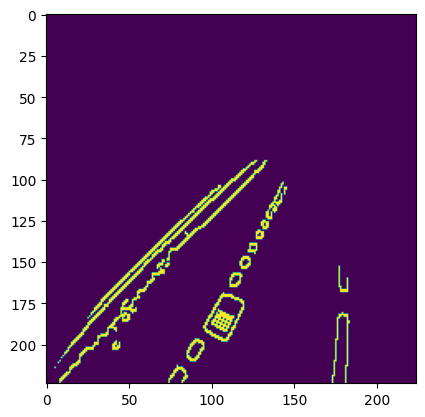

In [ ]:
plt.imshow(X[0])

In [ ]:
preds = model.predict(X)

273/273 [==============================] - 2s 6ms/step


In [ ]:
y[0]

array([-0.7265625])

In [ ]:
preds[0]

array([-0.87222254], dtype=float32)

array([-0.0751134], dtype=float32)

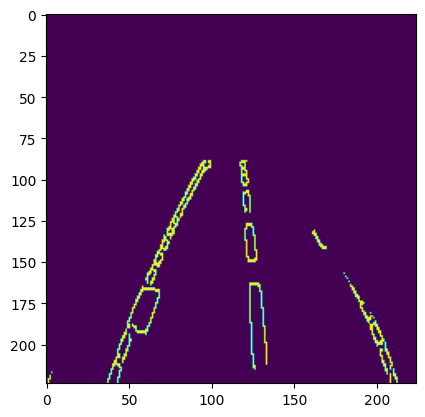

In [ ]:
plt.imshow(X[20])
preds[20]

In [ ]:
!pip install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 44.2 MB/s eta 0:00:00


In [ ]:
import tf2onnx
import onnx

MODEL_NAME = 'minimal'
MODEL_PATH = 'drive/MyDrive/Colab Notebooks/ROBOTICS/project-jetbot/' + MODEL_NAME + '.onnx'

model = keras.saving.load_model("model_checkpoint.h5")
onnx_model, _ = tf2onnx.convert.from_keras(model, opset=13)
onnx.save(onnx_model, MODEL_PATH)

# spec = (tf.TensorSpec((None, FRAMES_TO_STACK, FINAL_HEIGHT, 224, 3), tf.float32, name="input"),)
# model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=MODEL_PATH)